In [1]:
import numpy as np
from scipy import linalg
import scipy.sparse.linalg as spla
from scipy.sparse import csc_matrix, diags, eye, kron

# plotting
import matplotlib.pyplot as plt
from matplotlib import gridspec
from mpl_toolkits.mplot3d import Axes3D 

In [2]:
a = diags(np.ones(2), 0)
b = diags([10, 12], 0)
(a - b).toarray()

array([[ -9.,   0.],
       [  0., -11.]])

## helper functions

In [3]:
def printmatrix(mat, **kwargs):
    fp = kwargs.get("fp", 3)    # number of floating points
    bs = kwargs.get("bs", 8)   # number of blank-spaces
    format_dict = {
        'float_kind': lambda x: f"{x:>{bs}.{fp}f}",
        'bool': lambda x: False if x == 0 else True,
        }
    formatter = kwargs.get("formatter", format_dict)
    linewidth = kwargs.get("linewidth", None)
    if linewidth is None:
        linewidth = kwargs.get("lw", 100)
    with np.printoptions(formatter=formatter, linewidth=linewidth):
        print(mat)

# Exercise 2b) 5- and 9-point Laplacian

## c) Implement 5-point Laplacian scheme. Check expected convergence
Use the exact solution:
$$\begin{align*}
    u_\mathrm{exact}(x,y) &= \sin{\left(4\pi(x + y)\right)} + \cos{\left(4\pi xy\right)}
\end{align*}$$

## The 5-point Laplacian

Let $u_{ij} = u(x_i, y_j)$, for a step-size equal in $x$ and $y$
$$\begin{align*}
    \nabla^2 u &= \frac{\partial^2 u}{\partial x^2} + \frac{\partial^2 u}{\partial y^2}
    \\
    \frac{\partial^2 u}{\partial x^2} &\approx \frac{u_{i-1,j} - 2u_{ij} + u_{i+1,j}}{h^2}
    \\
    \frac{\partial^2 u}{\partial y^2} &\approx \frac{u_{i,j-1} - 2u_{ij} + u_{i, j+1}}{h^2}
    \\
    \nabla^2u &\approx \frac{u_{i-1,j} - 2u_{ij} + u_{i+1,j}}{h^2} + \frac{u_{i,j-1} - 2u_{ij} + u_{i, j+1}}{h^2} 
    \\ &= \frac{u_{i-1,j} + u_{i,j-1} - 4u_{ij} + u_{i+1,j} + u_{i,j+1}}{h^2}

\end{align*}$$

## Creating grid

For computational relevancy we want to make the solution array $u_{ij}$ 2D $\to$ 1D; if doing this row-wise we get

$$\begin{align*}
    U = \begin{bmatrix}
        u_{00} & u_{10} & u_{20} \\
        u_{01} & u_{11} & u_{21} \\
        u_{02} & u_{12} & u_{22} \\
    \end{bmatrix}
    \to 
    \begin{bmatrix}
        u_{00} \\ u_{10} \\ u_{20} \\
        u_{01} \\ u_{11} \\ u_{21} \\
        u_{02} \\ u_{12} \\ u_{22} \\
    \end{bmatrix}
\end{align*}$$

This gives us $N\times N$ uknowns, and so the solution matrix, $A$, is $A\in \mathbb{R}^{N^2\times N^2}$

Remember, that for a 5-point Laplacian, we should have $u_{00} = u_{20} = {u_02} = u_{22} = 0$ and the left, right, top, and bottom neighbours, $u_{10} = u_{01} = u_{21} = u_{12} = 1$, and the center point should be $u_{11} = - 4$

$$\begin{align*}
    A_{11} = \begin{bmatrix}
        0 & 1 & 0 \\
        1 & -4 & 1 \\
        0 & 1 & 0 \\
    \end{bmatrix}
    \to 
    \begin{bmatrix}
        0 & 1 & 0 &
        1 & -4 & 1 &
        0 & 1 & 0 \\
    \end{bmatrix}
\end{align*}$$

for the $k$'th index $k:=k_{ij} = i + jN$.

So, for the 5-point Laplacian, the system matrix, $A$, should have
* A diagonal of $k_{ii} = -4$
* NN poitns of element $k_{i\pm 1, j}, k_{i,k\pm1} = 1$:
    * $k_{i\pm 1, j} = k_{ij} \pm 1$
    * $k_{i, j\pm 1} = k_{ij} \pm N$

In [4]:
from sympy import symbols, diff, sin, cos, pi, latex
from IPython.display import Math
x, y = symbols("x y")
u = sin(4*pi*(x + y)) + cos(4*pi*x*y)
upp = u.diff(x,2) + u.diff(y,2)
upp = upp.simplify()

display(Math(rf"$\nabla^2 = {latex(upp)}$"))

<IPython.core.display.Math object>

We want to create a 5-point Laplacian, and we will compare it to a given function:
$$\begin{align*}
    u_\mathrm{exact}(x,y) &= \sin{\left(4\pi(x + y)\right)} + \cos{\left(4\pi xy\right)}
    \\
    \nabla^2 u_\mathrm{exact}(x,y) &= -(4\pi)^2\bigg( \Big(x^2 + y^2\Big) \cos(4\pi x y) + 2 \sin(4\pi(x+y))\bigg)
\end{align*}$$

When evaluating the expression on $x_i,y_j$ we have $U_{ij} = u(x_i,y_j)$
Applying the double centeret stencil, $D_i^2U_{ij}$ gives us
$$\begin{align*}
    \dfrac{\partial^2 U_{ij}}{\partial x_i^2} &\approx \dfrac{U_{i+1,j} -2U_{i,j} + U_{i-1,j}}{h^2}
    \\
    \dfrac{\partial^2 U_ij}{\partial y_j^2} &\approx \dfrac{U_{i,j+1} -2U_{i,j} + U_{i,j-1}}{h^2}
    \\
    \nabla^2U_{ij} &\approx \dfrac{U_{i+1,j} + U_{i,j+1} + U_{i-1,j} + U_{i,j-1} -4U_{i,j}}{h^2}
\end{align*}$$

This yields the Laplacian matrix
$$\begin{align*}
    A &= \dfrac{1}{h^2}
    \begin{pmatrix}
        -4 & 1 & 0 & 0 & 0 & 0 \\
        1  &-4 & 1 & 0 & 0 & 0\\
        0  & 1 &-4 & 1 & 0 & 0\\
        0  & 0 & 1 &-4 & 1 & 0\\
        0  & 0 & 0 & 1 & -4& 1\\
        0  & 0 & 0 & 0 & 1 &-4
    \end{pmatrix}
\end{align*}$$

Now if we want to solve the grid, it is convenient to use 1D representation of the grid, and therefore we construct a matrix being $A\in \mathbb{R}^{N^2\times N^2}$ to our 1D representation of the stencil-approximation $U\in\mathbb{R}^{N^2}$

$$\begin{align*}
    A &= \frac{1}{h^2}\left(T_2\otimes I + I \otimes T_2\right), \quad T_\gamma = \begin{pmatrix}
    -\gamma & 1 & 0 \\ 
     1 & -\gamma & 1 \\ 
     0 & 1 & -\gamma \end{pmatrix}
     \\
     &= \frac{1}{h^2} 
     \left(\begin{array}{c|c|c}
        T_4 & I & 0 \\\hline 
        I & T_4 & I \\\hline
        0 & I & T_4
     \end{array}\right)
\end{align*}$$

In [131]:
def laplace_5_point(N):
    """Compute 5-point Laplacian on uniform grid `[0,1] x [0,1]`
    
    Parameters
    ---
    N : int,
        Number of interior points in x-diraction and y-direction (for a total of N**2 points)
    
    Returns
    ---
    A : sparse ndarray of size `(N**2, N**2)`,
        The 5-point laplacian
    """
    h = 1/(N+1)
    main     = -2*np.ones(N)
    off_diag = np.ones(N-1)
    T2 = diags([off_diag, main, off_diag], offsets=[1, 0, -1], shape=(N,N), format="csc")
    I = eye(N, format="csc") # Identity matrix of size N x N
    A = kron(T2, I, format="csc") + kron(I, T2, format="csc")
    return (N+1)**2 * A # A / h**2  = A * (N+1)**2

def u_exact(x, y):
    C = 4* np.pi
    return np.sin(C*(x+y)) + np.cos(C*x*y)

def upp(x, y):
    C = 4 * np.pi
    return -C**2 * ( 2*np.sin(C*(x + y)) + (x**2 + y**2) * np.cos(C*x*y))


def solve_poisson(N_interior, f_func, g_func):
    """Solve Poisson equation.
    
    Parameters
    ---
    N : int,
        Number of interior points
    f_func : callable,
        RHS of poisson's equaiont, taking arguments `(x,y)`
    g_func : callable,
        Function for boundary values, taking arguments `(x,y)`.
    
    Returns
    ---
    A : sparse ndarray of size `(N**2, N**2)`,
        the 5-point Laplacian
    U : ndarray of size `(N**2)`,
        the 1D representation of `U`
    F : ndarray of size `(N**2)`,
        The right hand side of poissons equation
    """
    h = 1/(N_interior+1)
    xy = np.arange(0+h, 1, h) # from 0+h to 1-h
    X, Y = np.meshgrid(xy, xy, indexing="xy") # X increases along columns, Y increases down rows
    
    F = f_func(X, Y)
    
    F[0, :] -= 1/h**2 * g_func(xy, 0) # boundary for y=0 
    F[-1,:] -= 1/h**2 * g_func(xy, 1) # boundary for y=1
    F[:, 0] -= 1/h**2 * g_func(0, xy) # boundary for x=0
    F[:,-1] -= 1/h**2 * g_func(1, xy) # boundary for x=1
    
    F = F.flatten()
    A = laplace_5_point(N_interior)
    # print(f"{F.shape = }")
    # print(f"{A = }")
    U = spla.spsolve(A, F)
    return A, U, F

A, U, F = solve_poisson(10, upp, u_exact)
A.shape, U.shape, F.shape

((100, 100), (100,), (100,))

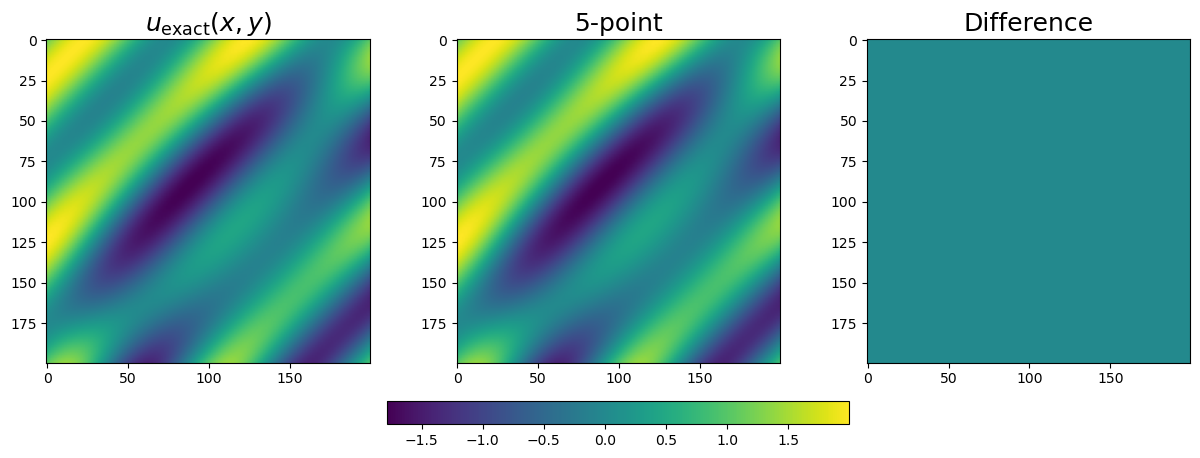

In [135]:
LABELSIZE = 15
fig, ax = plt.subplots(1, 3, figsize=(15, 5))
N = 200
h = 1/(N+1)
xy = np.arange(0+h, 1, h)

X, Y = np.meshgrid(xy, xy, indexing="xy")
U_EXACT = u_exact(X, Y)
A_h, U_h, F_h = solve_poisson(N, upp, u_exact)

U_DIFF = U_EXACT - U_h.reshape(N, N)

# Get the global min and max values for consistent color scaling
vmin = min(U_EXACT.min(), U_h.min(), U_DIFF.min())
vmax = max(U_EXACT.max(), U_h.max(), U_DIFF.max())

# Plot each subplot with the same color limits
cax0 = ax[0].imshow(U_EXACT, vmin=vmin, vmax=vmax)
ax[0].set_title(r"$u_\mathrm{exact}(x,y)$", size=LABELSIZE+3)

cax1 = ax[1].imshow(U_h.reshape(N, N), vmin=vmin, vmax=vmax)
ax[1].set_title("5-point", size=LABELSIZE+3)

cax2 = ax[2].imshow(U_DIFF, vmin=vmin, vmax=vmax)
ax[2].set_title("Difference", size=LABELSIZE+3)

# Add a colorbar that spans all three plots
cbar = fig.colorbar(cax2, ax=ax, location='bottom', fraction=0.06, pad=0.1)
# plt.tight_layout()
# plt.show()

In [43]:
# ## For plotting imshow() and 3D
# M = 200
# h = 1/(M+1)
# xy = np.arange(0+h, 1, h)
# X, Y = np.meshgrid(xy, xy, indexing="xy")
# # print(X[:5, :5] - h)
# A, U, F = solve_poisson(M, upp, u_exact)
# U = U.reshape(M,M)
# U_EXACT = u_exact(X, Y)

# vmin = np.min([U_EXACT.min(), U.min()])
# vmax = np.max([U_EXACT.max(), U.max()])

# ## Plotting
# fig =  plt.figure(figsize=(10,12))
# gs = gridspec.GridSpec(3, 3, height_ratios=(1, 1, 1))

# ax1 = fig.add_subplot(gs[0, 0])
# ax2 = fig.add_subplot(gs[0, 1])
# ax3 = fig.add_subplot(gs[0, 2])


# im1 = ax1.imshow(U_EXACT, vmin=vmin, vmax=vmax)
# ax1.set_title(r"$u_\mathrm{exact}(x,y)$", size=20)


# im2 = ax2.imshow(U, vmin=vmin, vmax=vmax)
# ax2.set_title("5-point-Laplacian", size=20)


# im3 = ax3.imshow(U-U_EXACT, vmin=vmin, vmax=vmax)
# ax3.set_title("difference", size=20)


# # Add 3D surface plots
# ax4 = fig.add_subplot(gs[1, 0], projection='3d')
# ax5 = fig.add_subplot(gs[1, 1], projection='3d')
# ax6 = fig.add_subplot(gs[1, 2], projection='3d')

# ax4.plot_surface(X, Y, U_EXACT, cmap="viridis")
# ax5.plot_surface(X, Y, U, cmap="viridis")
# ax6.plot_surface(X, Y, U - U_EXACT, cmap="viridis")


# fig.colorbar(cax=im3, ax=[ax1, ax2, ax3], orientation="vertical")
# fig.tight_layout()
# fig.show()

N = 20
N = 40
N = 80
N = 160
N = 320


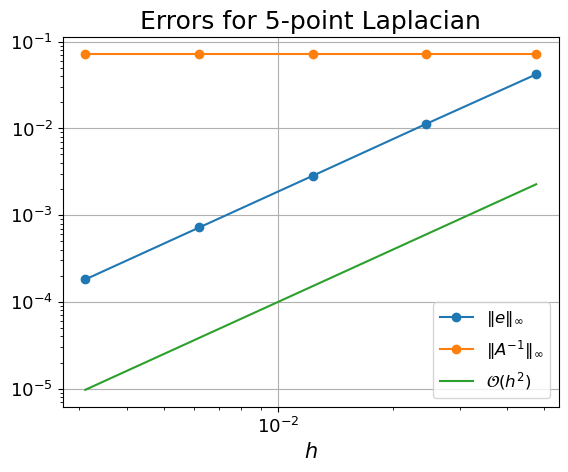

In [133]:
Ns = np.array([2**i * 20 for i in range(5)])

errors = []
norms = []
for N in Ns:
    print(f"N = {N}")
    A_h, U_h, F_h = solve_poisson(N, f_func=upp, g_func=u_exact)
    h = 1/(N+1)
    xy = np.arange(0+h, 1, h)
    X, Y = np.meshgrid(xy, xy, indexing="xy")
    U_EXACT = u_exact(X, Y).flatten()
    # print(f"{U_EXACT.shape = }")
    # print(f"    {U_h.shape = }")
    err = linalg.norm(U_h - U_EXACT, np.inf)
    norm_A_inv = spla.norm(spla.inv(A), np.inf)
    errors.append(err)
    norms.append(norm_A_inv)

errors = np.array(errors); errors
norms = np.array(norms); norms
fig, ax = plt.subplots()
hs = 1/(Ns+1)
ax.loglog(hs, errors, "-o", label=r"$\|e\|_\infty$")
ax.loglog(hs, norms, "-o", label=r"$\|A^{-1}\|_\infty$")
ax.loglog(hs, hs**2, label=r"$\mathcal{O}(h^2)$")
# ax.loglog(hs, hs**3, label=r"$\mathcal{O}(h^3)$")
ax.set_xlabel("$h$", size=LABELSIZE)
ax.tick_params(axis="both", labelsize=LABELSIZE-2)
ax.set_title("Errors for 5-point Laplacian", size=LABELSIZE+3)
ax.legend(fontsize=LABELSIZE-3)
ax.grid()

# 9-point Laplacian

In [ ]:
def laplace9(N):
    """Based on the MATLAB code from Lecture 4 slides"""
    h = (N+1)    
    S = diags([    -np.ones(N-1), -10*np.ones(N),     -np.ones(N-1)], [-1, 0, 1], shape=(N,N), format="csc")
    I = diags([-0.5*np.ones(N-1),     np.ones(N), -0.5*np.ones(N-1)], [-1, 0, 1], shape=(N,N), format="csc")
    return 1/(6*h**2) * (kron(I, S, format="csc") + kron(S, I,format="csc"))


def poisson9(N_interior, f_func, g_func):
    """Solve Poisson equation.
    
    Parameters
    ---
    N : int,
        Number of interior points
    f_func : callable,
        RHS of poisson's equaiont, taking arguments `(x,y)`
    g_func : callable,
        Function for boundary values, taking arguments `(x,y)`.
    
    Returns
    ---
    A : sparse ndarray of size `(N**2, N**2)`,
        the 5-point Laplacian
    U : ndarray of size `(N**2)`,
        the 1D representation of `U`
    F : ndarray of size `(N**2)`,
        The right hand side of poissons equation
    """
    print(f"{N_interior = }")
    h = 1/(N_interior+1)
    xy = np.arange(0+h, 1, h) # from 0+h to 1-h
    X, Y = np.meshgrid(xy, xy, indexing="xy") # X increases along columns, Y increases down rows
    
    A5 = laplace_5_point(N_interior)
    
    # print(f"{F5.shape = }")
    F = f_func(X, Y) + (1/12) * h**2 * (A5@(f_func(X, Y).flatten())).reshape(N_interior, N_interior)
    
    F[0, :] -= 1/h**2 * g_func(xy, 0) # boundary for y=0 
    F[-1,:] -= 1/h**2 * g_func(xy, 1) # boundary for y=1
    F[:, 0] -= 1/h**2 * g_func(0, xy) # boundary for x=0
    F[:,-1] -= 1/h**2 * g_func(1, xy) # boundary for x=1
    
    F[ 0, 0] -= 1/h**2 *g_func(0,0)
    F[ 0,-1] -= 1/h**2 *g_func(0,1)
    F[-1, 0] -= 1/h**2 *g_func(1,0)
    F[-1,-1] -= 1/h**2 *g_func(1,1)
    
    F = F.flatten()
    A = laplace9(N_interior)
    U = spla.spsolve(A, F)
    return A, U, F

A, U, F = poisson9(10, upp, u_exact)

N_interior = 10


N_interior = 200


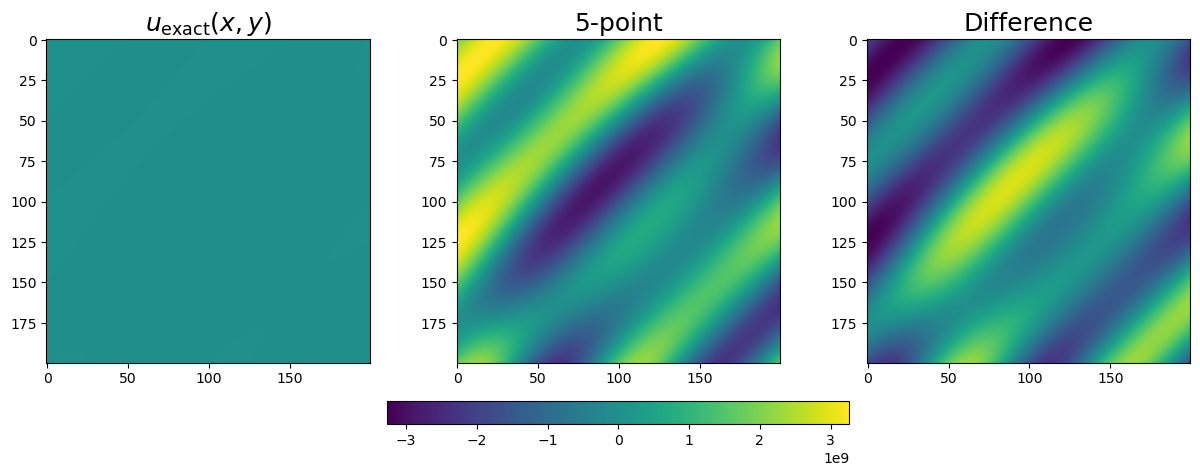

In [130]:
LABELSIZE = 15
fig, ax = plt.subplots(1, 3, figsize=(15, 5))
N = 200
h = 1/(N+1)
xy = np.arange(0+h, 1, h)
X, Y = np.meshgrid(xy, xy, indexing="xy")
U_EXACT = u_exact(X, Y)
A_h, U_h, F_h = poisson9(N, upp, u_exact)

U_DIFF = U_EXACT - U_h.reshape(N, N)

# Get the global min and max values for consistent color scaling
vmin = min(U_EXACT.min(), U_h.min(), U_DIFF.min())
vmax = max(U_EXACT.max(), U_h.max(), U_DIFF.max())

# Plot each subplot with the same color limits
cax0 = ax[0].imshow(U_EXACT, vmin=vmin, vmax=vmax)
ax[0].set_title(r"$u_\mathrm{exact}(x,y)$", size=LABELSIZE+3)

cax1 = ax[1].imshow(U_h.reshape(N, N), vmin=vmin, vmax=vmax)
ax[1].set_title("5-point", size=LABELSIZE+3)

cax2 = ax[2].imshow(U_DIFF, vmin=vmin, vmax=vmax)
ax[2].set_title("Difference", size=LABELSIZE+3)

# Add a colorbar that spans all three plots
cbar = fig.colorbar(cax2, ax=ax, location='bottom', fraction=0.06, pad=0.1)
# plt.tight_layout()
# plt.show()
